In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

import time


In [2]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [3]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


# My function to calculate 0 dimensional Persistent Homology in Pytorch

In [45]:
def get_zero_dim_PH(dist_matrix):
    upp_diag = torch.triu(dist_matrix, diagonal=1)

    ff = upp_diag.sort()

    sorted_upper_diag_edges = ff[0]
    #sorted_upper_diag_indices = ff[1]

    flattened_uppdg_edges = torch.flatten(sorted_upper_diag_edges)

    non_zero_flattened_uppdg_edges = flattened_uppdg_edges[flattened_uppdg_edges.nonzero()]


    non_zero_flattened_uppdg_edges = non_zero_flattened_uppdg_edges.reshape(non_zero_flattened_uppdg_edges.shape[0])

    increasing_edges = non_zero_flattened_uppdg_edges.sort()[0]


    selected_edges = torch.tensor([])
    dead_indices = torch.tensor([])
    for i in range(increasing_edges.shape[0]):
        a = (upp_diag == increasing_edges[i]).nonzero(as_tuple=False)
        b = a[0][0]
        b = b.reshape(1,1)  
        if(b==0):
            c = a[0][1]
            if(not(c in dead_indices) ):

                c = c.reshape(1,1)  
                dead_indices = torch.cat(((dead_indices, c)), 0)
                selected_edges = torch.cat(((selected_edges, a)), 0)

        elif(not(b in dead_indices) or not(a[0][1] in dead_indices) ):
            if(b in dead_indices):
                d = a[0][1]
                d = d.reshape(1,1)
                dead_indices = torch.cat(((dead_indices, d)), 0)
                selected_edges = torch.cat(((selected_edges, a)), 0)

            else:
                dead_indices = torch.cat(((dead_indices, b)), 0)
                selected_edges = torch.cat(((selected_edges, a)), 0)

    zeroD_PH = torch.tensor([])
    for i in range(selected_edges.shape[0]):    
        death = dist_matrix[int(selected_edges[i][0])][int(selected_edges[i][1])]
        death = death.reshape(1,1)
        zeroD_PH = torch.cat(((zeroD_PH, death)), 0)

        births = torch.zeros(zeroD_PH.shape[0], 1)
    zeroD_PH_births_deaths = torch.cat((births, zeroD_PH ),1)
    
    return zeroD_PH_births_deaths

In [78]:

PH_7_giving_30_points = torch.tensor([[ 0.5738, -0.1217,  0.8099],
        [-0.4035,  0.7019, -0.5870],
        [ 0.7303, -0.3869,  0.5630],
        [ 0.8971,  0.3825,  0.2210],
        [ 0.4737,  0.6196,  0.6259],
        [ 0.2366,  0.3971, -0.8868],
        [-0.8723, -0.3745, -0.3145],
        [-0.1204,  0.1281, -0.9844],
        [ 0.3959,  0.6088, -0.6875],
        [-0.8566,  0.1515,  0.4933],
        [-0.0366, -0.6735,  0.7383],
        [ 0.1010, -0.3231, -0.9410],
        [-0.9367, -0.2104,  0.2798],
        [-0.4023,  0.2617, -0.8773],
        [-0.7749,  0.4295, -0.4638],
        [ 0.4113,  0.6073,  0.6797],
        [ 0.1690,  0.7614, -0.6259],
        [-0.3786, -0.4929, -0.7834],
        [ 0.3846,  0.2930,  0.8753],
        [-0.3639, -0.6566,  0.6607],
        [-0.5986,  0.7731,  0.2096],
        [ 0.6488, -0.3099, -0.6950],
        [-0.4391, -0.6711, -0.5974],
        [ 0.3209, -0.6878, -0.6511],
        [ 0.7513,  0.3147, -0.5801],
        [ 0.3028,  0.8917,  0.3365],
        [ 0.1806, -0.9513, -0.2499],
        [-0.5198, -0.6968,  0.4943],
        [-0.9573, -0.1228, -0.2618],
        [-0.2985,  0.5618,  0.7716]], dtype=torch.float64)

PH_8_giving_40_points = torch.tensor([[-0.1724,  0.6586,  0.7325],
        [ 0.2713, -0.1220,  0.9547],
        [ 0.1882, -0.9015, -0.3897],
        [-0.9445,  0.3227, -0.0617],
        [-0.7393, -0.4762,  0.4760],
        [-0.0352,  0.7986, -0.6009],
        [ 0.1162, -0.3318, -0.9362],
        [-0.0163, -0.1476,  0.9889],
        [ 0.7336, -0.6714, -0.1050],
        [-0.4835,  0.5424, -0.6871],
        [ 0.8664, -0.1362, -0.4805],
        [-0.5724, -0.5164, -0.6369],
        [ 0.5185,  0.8413,  0.1531],
        [-0.1293, -0.7402,  0.6598],
        [-0.2941,  0.9557, -0.0104],
        [ 0.2436,  0.9354, -0.2562],
        [-0.0104,  0.6418, -0.7668],
        [-0.7085, -0.5757,  0.4082],
        [-0.4029,  0.8635, -0.3034],
        [-0.7054,  0.7084,  0.0221],
        [ 0.4764, -0.8767, -0.0664],
        [ 0.3562,  0.3095,  0.8816],
        [ 0.4282, -0.2256, -0.8751],
        [ 0.9888,  0.1135,  0.0972],
        [ 0.6825, -0.7305,  0.0236],
        [-0.4627, -0.4586,  0.7587],
        [-0.5022, -0.3980, -0.7677],
        [-0.6761, -0.3225,  0.6625],
        [ 0.7988, -0.5689,  0.1955],
        [-0.7241,  0.3728,  0.5803],
        [ 0.0757, -0.5107,  0.8564],
        [-0.1718, -0.6691, -0.7231],
        [ 0.7733,  0.5120,  0.3739],
        [-0.4602, -0.8877,  0.0103],
        [-0.1742, -0.6330,  0.7543],
        [-0.3916, -0.9182,  0.0597],
        [-0.7885, -0.5381,  0.2980],
        [-0.4943, -0.4132, -0.7648],
        [ 0.2958,  0.9391,  0.1747],
        [ 0.7773,  0.6242,  0.0794]], dtype=torch.float64)

# Point cloud 1

In [47]:

trial_points = torch.tensor([[ 0.5738, -0.1217,  0.8099],
        [-0.4035,  0.7019, -0.5870],
        [ 0.7303, -0.3869,  0.5630],
        [ 0.8971,  0.3825,  0.2210],
        [ 0.4737,  0.6196,  0.6259],
        [ 0.2366,  0.3971, -0.8868],
        [-0.8723, -0.3745, -0.3145]], dtype=torch.float64)

### Distance matrix

In [48]:
distance_matrix = _compute_distance_matrix(trial_points, p=2)

distance_matrix

tensor([[0.0000, 1.8933, 0.3947, 0.8400, 0.7703, 1.8060, 1.8492],
        [1.8933, 0.0000, 1.9477, 1.5641, 1.4991, 0.7697, 1.2053],
        [0.3947, 1.9477, 0.0000, 0.8583, 1.0406, 1.7206, 1.8272],
        [0.8400, 1.5641, 0.8583, 0.0000, 0.6320, 1.2898, 1.9976],
        [0.7703, 1.4991, 1.0406, 0.6320, 0.0000, 1.5473, 1.9195],
        [1.8060, 0.7697, 1.7206, 1.2898, 1.5473, 0.0000, 1.4672],
        [1.8492, 1.2053, 1.8272, 1.9976, 1.9195, 1.4672, 0.0000]],
       dtype=torch.float64)

### Computing Persistent Homology using ripser

In [49]:
start = time.time()

diagrams = ripser.ripser(distance_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=7)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

Runtime of the program is 0.0010080337524414062


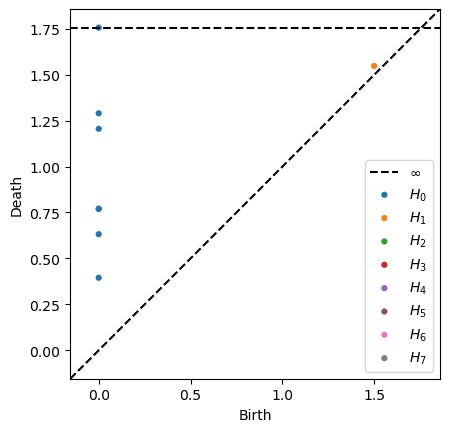

In [50]:
plot_diagrams(diagrams, show=True)

In [51]:
diagrams

[array([[0.        , 0.39469343],
        [0.        , 0.63200313],
        [0.        , 0.76974744],
        [0.        , 0.77032572],
        [0.        , 1.20526624],
        [0.        , 1.28984272],
        [0.        ,        inf]]),
 array([[1.49912632, 1.54725039]]),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64)]

### Computing PH using new method

In [52]:

start = time.time()

get_zero_dim_PH(distance_matrix)

end = time.time()

print(f"Runtime of the program is {end - start}")

Runtime of the program is 0.0027930736541748047


# Point cloud 2

In [71]:
#get distance matrix

distance_matrix = _compute_distance_matrix(PH_7_giving_30_points, p=2)

distance_matrix

tensor([[0.0000, 1.8933, 0.3947, 0.8400, 0.7703, 1.8060, 1.8492, 1.9401, 1.6756,
         1.4903, 0.8260, 1.8248, 1.6033, 1.9866, 1.9352, 0.7582, 1.7336, 1.8930,
         0.4605, 1.0898, 1.5923, 1.5185, 1.8189, 1.5871, 1.4677, 1.1509, 1.4021,
         1.2753, 1.8689, 1.1088],
        [1.8933, 0.0000, 1.9477, 1.5641, 1.4991, 0.7697, 1.2053, 0.7532, 0.8111,
         1.2943, 1.9449, 1.1960, 1.3667, 0.5273, 0.4768, 1.5091, 0.5769, 1.2111,
         1.7107, 1.8450, 0.8232, 1.4638, 1.3735, 1.5685, 1.2180, 1.1780, 1.7855,
         1.7717, 1.0453, 1.3698],
        [0.3947, 1.9477, 0.0000, 0.8583, 1.0406, 1.7206, 1.8272, 1.8394, 1.6331,
         1.6772, 0.8373, 1.6316, 1.7001, 1.9437, 1.9966, 1.0506, 1.7456, 1.7475,
         0.8242, 1.1312, 1.7990, 1.2630, 1.6718, 1.3161, 1.3414, 1.3671, 1.1320,
         1.2898, 1.8968, 1.4149],
        [0.8400, 1.5641, 0.8583, 0.0000, 0.6320, 1.2898, 1.9976, 1.5978, 1.0620,
         1.7897, 1.5015, 1.5754, 1.9282, 1.7057, 1.8074, 0.7049, 1.1794, 1.8446,
       

In [72]:
# using ripser

start = time.time()

diagrams = ripser.ripser(distance_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=0)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

diagrams[0]

Runtime of the program is 0.002143383026123047


array([[0.        , 0.0833036 ],
       [0.        , 0.23153792],
       [0.        , 0.26459685],
       [0.        , 0.27084163],
       [0.        , 0.28029436],
       [0.        , 0.32982871],
       [0.        , 0.3315326 ],
       [0.        , 0.33679765],
       [0.        , 0.37115595],
       [0.        , 0.39469343],
       [0.        , 0.42774978],
       [0.        , 0.43243217],
       [0.        , 0.45753226],
       [0.        , 0.46048874],
       [0.        , 0.47364411],
       [0.        , 0.47677875],
       [0.        , 0.50007778],
       [0.        , 0.50224894],
       [0.        , 0.50446302],
       [0.        , 0.51517385],
       [0.        , 0.52730596],
       [0.        , 0.5326218 ],
       [0.        , 0.54902524],
       [0.        , 0.59637755],
       [0.        , 0.63200313],
       [0.        , 0.67123151],
       [0.        , 0.67557442],
       [0.        , 0.71716934],
       [0.        , 0.73036718],
       [0.        ,        inf]])

In [76]:
# new method


start = time.time()

PH_torch = get_zero_dim_PH(distance_matrix)

end = time.time()

print(f"Runtime of the program is {end - start}")

Runtime of the program is 0.04267096519470215


In [77]:
PH_torch

tensor([[0.0000, 0.0833],
        [0.0000, 0.2315],
        [0.0000, 0.2646],
        [0.0000, 0.2708],
        [0.0000, 0.2803],
        [0.0000, 0.3298],
        [0.0000, 0.3315],
        [0.0000, 0.3368],
        [0.0000, 0.3712],
        [0.0000, 0.3947],
        [0.0000, 0.4205],
        [0.0000, 0.4277],
        [0.0000, 0.4324],
        [0.0000, 0.4532],
        [0.0000, 0.4736],
        [0.0000, 0.4768],
        [0.0000, 0.5001],
        [0.0000, 0.5022],
        [0.0000, 0.5045],
        [0.0000, 0.5273],
        [0.0000, 0.5418],
        [0.0000, 0.5490],
        [0.0000, 0.5814],
        [0.0000, 0.5964],
        [0.0000, 0.6157],
        [0.0000, 0.6320],
        [0.0000, 0.6712],
        [0.0000, 0.7172],
        [0.0000, 0.7637]], dtype=torch.float64)

# Point cloud 3

In [79]:
#get distance matrix

distance_matrix = _compute_distance_matrix(PH_8_giving_40_points, p=2)

distance_matrix

tensor([[0.0000, 0.9250, 1.9553,  ..., 1.8693, 0.7804, 1.1531],
        [0.9250, 0.0000, 1.5563,  ..., 1.9046, 1.3172, 1.2566],
        [1.9553, 1.5563, 0.0000,  ..., 0.9192, 1.9282, 1.7014],
        ...,
        [1.8693, 1.9046, 0.9192,  ..., 0.0000, 1.8264, 1.8455],
        [0.7804, 1.3172, 1.9282,  ..., 1.8264, 0.0000, 0.5832],
        [1.1531, 1.2566, 1.7014,  ..., 1.8455, 0.5832, 0.0000]],
       dtype=torch.float64)

In [85]:
# using ripser

start = time.time()

diagrams = ripser.ripser(distance_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=0)['dgms']

end = time.time()

print(f"Runtime of the program is {end - start}")

diagrams[0]

Runtime of the program is 0.0022568702697753906


array([[0.        , 0.01737412],
       [0.        , 0.08986974],
       [0.        , 0.12428085],
       [0.        , 0.14127208],
       [0.        , 0.14979352],
       [0.        , 0.15047252],
       [0.        , 0.18195675],
       [0.        , 0.22961727],
       [0.        , 0.24418578],
       [0.        , 0.24980028],
       [0.        , 0.26303965],
       [0.        , 0.26823804],
       [0.        , 0.2707715 ],
       [0.        , 0.29075551],
       [0.        , 0.29636416],
       [0.        , 0.3151747 ],
       [0.        , 0.3258639 ],
       [0.        , 0.33519495],
       [0.        , 0.33714533],
       [0.        , 0.3457478 ],
       [0.        , 0.39731833],
       [0.        , 0.41379941],
       [0.        , 0.43381697],
       [0.        , 0.43406606],
       [0.        , 0.44580698],
       [0.        , 0.46147129],
       [0.        , 0.46396312],
       [0.        , 0.47065115],
       [0.        , 0.4774113 ],
       [0.        , 0.48995516],
       [0.

In [86]:
# new method


start = time.time()

PH_torch = get_zero_dim_PH(distance_matrix)

end = time.time()

print(f"Runtime of the program is {end - start}")

Runtime of the program is 0.056728363037109375


In [87]:
PH_torch.shape

torch.Size([39, 2])